# Applied Programming Lab: Week 2 Submission
**by Niranjan A. Kartha (EE21B095)**

____

# Please use the notebook!

I have used the `ipynb` file to run and test code, as well as add documentation and explanations for it. So please use the Jupyter Notebook file as it provides a more streamlined experience.

____

# Running the notebook

This notebook uses the `numpy` and `matplotlib` libraries which need to be installed for the cells to run without errors.
The below cell should install the required libraries if they are not already installed.

In [562]:
import sys
!{sys.executable} -m pip install numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable


Using `{sys.executable} -m pip` rather than `pip` directly makes sure that we are installing `numpy` for the correct version of Python.

Now we can import the required libraries:

In [563]:
import numpy as np # for working with numbers
import timeit # for timing functions
import matplotlib.pyplot as plt # for plotting

____

# Performance in Python

Python is an interpreted language, and so every line needs to be parsed by the interpreter for it to be executed. It also does not implement any parallelization by default. It also has extra runtime overhead like a [garbage collector](https://devguide.python.org/internals/garbage-collector/). So, compared to a compiled language like C with manual memory management, it will be much slower.

## AOT Compilation

Languages like C and C++ are compiled ahead-of-time (AOT). This gives us a binary with instructions that can be directly executed by a processor. Assembly generated by C can be optimized by the compiler, and the processor can execute multiple assembly instructions at once through pipelining.

## JIT Compilation

Some of the disadvantages of Python performance-wise can be dealt with through just-in-time (JIT) compilation. This is the compilation of parts of a program during the execution of the program.

This adds some initial overhead as we need to compile the code each time we are running it, but as we run the same code again and again, the performance gain makes up for it.

Python interpreters like [PyPy](https://www.pypy.org/) support JIT compilation. We can perform JIT compilation in CPython (the "official" Python implementation) using libraries like [numba](https://numba.pydata.org/).

The below lines install and import the JIT compiler from `numba` for use in the program. This is only required for some of the cells in this notebook.

In [111]:
import sys
!{sys.executable} -m pip install numba

Defaulting to user installation because normal site-packages is not writeable


In [110]:
from numba import njit

____

# Factorial

Below are various different but equivalent ways to implement a factorial in Python.

In [93]:
# compute x factorial using recursion
def factorial_recursive(x):
    if x == 0:
        return 1
    return x * factorial_recursive(x - 1)

# compute x factorial using a for-loop
def factorial_for(x):
    prod = 1
    for i in range(1, x + 1):
        prod *= i
    return prod

# compute x factorial using a while-loop
def factorial_while(x):
    prod = 1
    while x > 0:
        prod *= x
        x -= 1
    return prod

# use python's builtin factorial function
import math
def factorial_builtin(x):
    return math.factorial(x)

# use numpy's built-in factorial function
def factorial_numpy(x):
    return np.math.factorial(x)

## Timing

In [64]:
num = 10

In [35]:
print(factorial_recursive(num))
%timeit factorial_recursive(num)

3628800
998 ns ± 42.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [94]:
print(factorial_for(num))
%timeit factorial_for(num)

3628800
529 ns ± 57.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [95]:
print(factorial_while(num))
%timeit factorial_while(num)

3628800
705 ns ± 35.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [91]:
print(factorial_builtin(num))
%timeit factorial_builtin(num)

3628800
129 ns ± 4.43 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [92]:
print(factorial_numpy(num))
%timeit factorial_numpy(num)

3628800
151 ns ± 1.19 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## Observations

### Built-in/library functions are faster than the hand-written ones
As we can see above, the `numpy` built-in factorial function is 3 to 6 times faster than our implementations made in Python, even though it provides identical functionality (even for large integers). This is because `numpy` does not compute the factorial in Python, and instead contains bindings to compiled C code.

### Looping is faster than recursion
We can also see that the looping version is twice as fast as the recursive one. This is because function calls add a lot of overhead. Each time we multiply a new number, the `factorial_recursive` function needs to be called, and this involves the creation of a whole new stack frame on the call stack.

### The `while`-loop version runs slower than the `for`-loop version
This is because `range` is a built-in Python function, and the incrementing and checks for the loop are done in optimized and compiled C code. In the `while` version, the incrementing and checks are done in Python.

## JIT-compiled tests

The JIT-compiled versions of these functions should run faster:

In [97]:
# compute x factorial using recursion
@njit
def factorial_recursive_jit(x):
    if x == 0:
        return 1
    return x * factorial_recursive_jit(x - 1)

# compute x factorial using a for-loop
@njit
def factorial_for_jit(x):
    prod = 1
    for i in range(1, x + 1):
        prod *= i
    return prod

# compute x factorial using a while-loop
@njit
def factorial_while_jit(x):
    prod = 1
    while x > 0:
        prod *= x
        x -= 1
    return prod

In [99]:
num = 10

In [107]:
print(factorial_recursive_jit(num))
%timeit -n 10000000 factorial_recursive_jit(num)

3628800
213 ns ± 11.3 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [108]:
print(factorial_for_jit(num))
%timeit -n 10000000 factorial_for_jit(num)

3628800
193 ns ± 4.61 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [109]:
print(factorial_while_jit(num))
%timeit -n 10000000 factorial_while_jit(num)

3628800
192 ns ± 6.09 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


All the code now runs natively, so there is no difference between the `for` and `while` versions. Also, the recursive version is now more optimized, since the JIT compiler also performs compile-time optimizations.

____

# Gaussian elimination

The below code performs Gaussian elimination with partial pivoting.

In [630]:
# solves Ax = b and returns x
def solve(A, b):
    A = np.array(A)
    b = np.array(b)
    n = A.shape[0] # number of unknowns
    B = np.concatenate((A, np.expand_dims(b, axis=1)), axis=1) # augmented matrix
    
    # bring B to row echelon form
    for i in range(0, n): # loop through diagonal elements
        
        # implement partial pivoting
        # find the maximum absolute value in this column
        max_k = i
        for k in range(i + 1, n):
            if np.abs(B[k][i]) > np.abs(B[max_k][i]):
                max_k = k
                
        if B[max_k][i] == 0:
            raise ZeroDivisionError("unsolvable matrix")
                
        # swap rows so that the maximum value is our new pivot
        B[[i, max_k]] = B[[max_k, i]]
        
        # reduce the values below
        for j in range(i + 1, n): # loop through rows below
            B[j,i:n+1] -= (B[j][i] / B[i][i]) * B[i,i:n+1]
        
    # now find the variables
    for i in range(n - 1, -1, -1): # loop up the matrix
        B[i][n] /= B[i][i]
        B[0:i,n] -= B[i][n] * B[0:i,i]
        
    return B[0:n,n]

In [374]:
solve([[2, 3], [1, -1]], [6, 1/2])

array([1.5, 1. ])

## Timing

Generate a random 10x10 matrix - the probability that this is singular [is theoretically zero](https://math.stackexchange.com/questions/1872323/if-i-generate-a-random-matrix-what-is-the-probability-of-it-to-be-singular).

In [375]:
A = np.random.rand(10, 10)
b = np.random.rand(10)

In [378]:
print(solve(A, b))
%timeit solve(A, b)

[-0.43331933  1.5397883   0.57460353 -1.59257912 -0.5757586   1.80358497
 -1.49157188  1.40018985  0.18384098 -0.27596619]
494 µs ± 4.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [379]:
print(np.linalg.solve(A, b))
%timeit np.linalg.solve(A, b)

[-0.43331933  1.5397883   0.57460353 -1.59257912 -0.5757586   1.80358497
 -1.49157188  1.40018985  0.18384098 -0.27596619]
7.03 µs ± 58.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As we can see above, the more code we execute within Python, the larger the disparity between using library and hand-written functions.

____

# SPICE

The below code blocks set up a `SpiceSolver` class which can be used to load and solve SPICE netlists, and also generate plots of transient voltages and currents.

## General class definitions

The classes below are representations of different components that we will use in the `SpiceSolver` class.

In [540]:
# an edge in the network that goes between two nodes
class Edge:
    def __init__(self, name, node_left, node_right):
        self.name = name
        self.node_left = node_left
        self.node_right = node_right
        
# a general passive component
class Passive(Edge):
    def __init__(self, name, node_left, node_right, value, cond=0):
        Edge.__init__(self, name, node_left, node_right)
        self.value = value
        self.cond = cond # condition, like voltage of a capacitor

# a general source (voltage or current)
class Source(Edge):
    def __init__(self, name, node_left, node_right, value, phase):
        Edge.__init__(self, name, node_left, node_right)
        self.value = value
        self.phase = phase

In [634]:
# class that parses a spice file and solves it
class SpiceSolver:
    def __init__(self):
        # we will replace all nodes with numbers in our matrix
        # this map will remember the mapping between node names and the numbering we assign
        self.node_map = { "GND": 0 }
        
        # number of nodes (excluding ground)
        self.node_count = 0
        
        # lists of sources by frequency
        self.voltages = { 0: [] }
        self.currents = { 0: [] }
        
        # lists of passive components
        self.resistors = []
        self.capacitors = []
        self.inductors = []
        
        # matrix of real conductances between nodes (excluding GND)
        # diagonal elements are the negative of the sum of the other conductances
        # this is used in common for solving equations at all frequencies
        self.conductance_matrix = None
        
        # matrix that is updated over time to obtain transient current and voltage values
        self.transient_matrix = None
        
        # RHS of linear equation for transient state
        self.transient_rhs = None
    
    def read_file(self, filename):
        # open file
        with open(filename) as f:
            l = f.readlines()
            
            if len(l) == 0:
                raise Exception("SPICE ERROR: empty file")

            # seek to start of circuit
            start = 0
            while len(l[start]) > 0 and l[start].split("#")[0].strip() != ".circuit":
                start += 1
                if start >= len(l):
                    raise Exception("SPICE ERROR: couldn't find start of circuit")
                    
            # find end of circuit
            end = start
            while len(l[end]) > 0 and l[end].split("#")[0].strip() != ".end":
                end += 1
                if end >= len(l):
                    raise Exception("SPICE ERROR: couldn't find end of circuit")
            
            # generate a map of source names to frequencies
            frequencies = {}
            
            # loop through lines after the ".end" directive
            for i in range(end + 1, len(l)):
                command = l[i].split('#')[0].split() # get command
                
                if command[0] == "":
                    continue
                
                # look for and parse ".ac" command
                if command[0].lower() == ".ac":
                    if len(command) != 3:
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            "invalid number of arguments"
                        )
                        
                    if command[1].upper() in frequencies:
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            "redefinition of freqency"
                        )
                        
                    try:
                        # add frequency to dictionary
                        freq = float(command[2])
                        frequencies[command[1].upper()] = freq
                        
                        self.voltages[freq] = []
                        self.currents[freq] = []
                        
                    except ValueError:
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            f"couldn't parse as number: {command[2]}"
                        )
            
            # generate a list of nodes and components, and check syntax
            for i in range(start + 1, end):
                command = l[i].split('#')[0].split()

                if command[0] == "":
                    continue
                    
                if len(command) < 4:
                    raise Exception(
                        f"SPICE ERROR on line {i + 1}:\n" +
                        l[i] + "\n" +
                        "invalid number of arguments"
                    )
                
                # the second and third commands will contain node names
                # add the nodes mentioned to our node map if they aren't already in it
                for j in [1, 2]:
                    if command[j].upper() not in self.node_map:
                        self.node_count += 1
                        self.node_map[command[j].upper()] = self.node_count
                
                # type of component
                ctype = l[i][0].upper()

                # parse passive components
                if ctype in ["R", "L", "C"]:
                    if len(command) not in [4, 5]: # 5th argument is the initial condition
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            "invalid number of arguments"
                        )
                    try:
                        edge = Passive(
                            command[0],
                            self.node_map[command[1].upper()],
                            self.node_map[command[2].upper()],
                            float(command[3])
                        )
                    except ValueError:
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            f"couldn't parse as number: `{command[3]}`"
                        )
                    
                    if len(command) == 5:
                        try:
                            edge.cond = float(command[4])
                        except ValueError:
                            raise Exception(
                                f"SPICE ERROR on line {i + 1}:\n" +
                                l[i] + "\n" +
                                f"couldn't parse as number: `{command[5]}`"
                            )
                        
                    # add to different array based on type
                    if ctype == "R":
                        self.resistors.append(edge)
                    elif ctype == "L":
                        self.inductors.append(edge)
                    else:
                        self.capacitors.append(edge)
                        
                # parse sources
                elif ctype in ["V", "I"]:
                    freq = 0
                    phase = 0
                    
                    if command[3].lower() == "ac":
                        if len(command) != 6:
                            raise Exception(
                                f"SPICE ERROR on line {i + 1}:\n" +
                                l[i] + "\n" +
                                "invalid number of arguments"
                            )
                        
                        if command[0].upper() in frequencies:
                            freq = frequencies[command[0].upper()]
                            try:
                                phase = float(command[5])
                            except ValueError:
                                raise Exception(
                                    f"SPICE ERROR on line {i + 1}:\n" +
                                    l[i] + "\n" +
                                    f"couldn't parse as number: {command[5]}"
                                )
                        else: # throw an error if the frequency for this source is not defined
                            raise Exception(
                                f"SPICE ERROR on line {i + 1}:\n" +
                                l[i] + "\n" +
                                f"could not find frequency for AC source: `{command[0]}`"
                            )
            
                    elif command[3].lower() == "dc":
                        if len(command) != 5:
                            raise Exception(
                                f"SPICE ERROR on line {i + 1}:\n" +
                                l[i] + "\n" +
                                "invalid number of arguments"
                            )
                    else:
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            f"invalid source type: `{command[3]}`"
                        )
                    
                    try:
                        edge = Source(
                            command[0],
                            self.node_map[command[1].upper()],
                            self.node_map[command[2].upper()],
                            float(command[4]),
                            phase,
                        )
                    except ValueError:
                        raise Exception(
                            f"SPICE ERROR on line {i + 1}:\n" +
                            l[i] + "\n" +
                            f"couldn't parse as number: {command[4]}"
                        )
                    if ctype == "V":
                        self.voltages[freq].append(edge)
                    else:
                        self.currents[freq].append(edge)
                        
                else:
                    raise Exception(
                        f"SPICE ERROR on line {i + 1}:\n" +
                        l[i] + "\n" +
                        "unidentified command inside circuit"
                    )
                    
        # generate a conductance matrix from the values we've read
        self.__gen_conductance_matrix()
        
    # generate the conductance matrix
    def __gen_conductance_matrix(self):
        self.conductance_matrix = np.zeros((self.node_count, self.node_count), dtype=np.complex_)
        
        for r in self.resistors:
            g = 1 / r.value
            
            if r.node_left == 0 or r.node_right == 0:
                other_node = np.max([r.node_left, r.node_right])
                self.conductance_matrix[other_node - 1][other_node - 1] -= g
            else: 
                self.conductance_matrix[r.node_left - 1][r.node_right - 1] += g
                self.conductance_matrix[r.node_right - 1][r.node_left - 1] += g
                self.conductance_matrix[r.node_left - 1][r.node_left - 1] -= g
                self.conductance_matrix[r.node_right - 1][r.node_right - 1] -= g
    
    # create a solvable linear matrix equation from adjacency matrix and modified sources
    def __gen_solveable(self, modified_voltages, freq):
        w = 2j * np.pi * freq
        
        dim = self.node_count + len(modified_voltages) # number of dimensions in matrix
        
        mat = np.zeros((dim, dim), dtype=np.complex_)
        x = np.zeros(dim, dtype=np.complex_)
        
        mat[0:self.node_count, 0:self.node_count] = self.conductance_matrix
        
        # outward currents are taken as negative, active sign convention is followed for voltage sources
        
        # calculate effective complex conductances between nodes
        if freq != 0:
            for r in self.inductors:
                g = 1 / (w * r.value)

                if r.node_left == 0 or r.node_right == 0:
                    other_node = np.max([r.node_left, r.node_right])
                    mat[other_node - 1][other_node - 1] -= g
                else: 
                    mat[r.node_left - 1][r.node_right - 1] += g
                    mat[r.node_right - 1][r.node_left - 1] += g
                    mat[r.node_left - 1][r.node_left - 1] -= g
                    mat[r.node_right - 1][r.node_right - 1] -= g

            for r in self.capacitors:
                g = w * r.value

                if r.node_left == 0 or r.node_right == 0:
                    other_node = np.max([r.node_left, r.node_right])
                    mat[other_node - 1][other_node - 1] -= g
                else: 
                    mat[r.node_left - 1][r.node_right - 1] += g
                    mat[r.node_right - 1][r.node_left - 1] += g
                    mat[r.node_left - 1][r.node_left - 1] -= g
                    mat[r.node_right - 1][r.node_right - 1] -= g
        
        k = self.node_count
        
        for v in modified_voltages:
            # V_left - V_right = V_source
            
            if v.node_left != 0:
                mat[v.node_left - 1][k] = 1 # current
                mat[k][v.node_left - 1] = 1 # voltage
                
            if v.node_right != 0:
                mat[v.node_right - 1][k] = -1 # current
                mat[k][v.node_right - 1] = -1 # voltage
            
            x[k] = v.value * np.exp(1j * v.phase)
            k += 1
            
        for i in self.currents[freq]:
            if i.node_left != 0:
                x[i.node_left - 1] = i.value * (np.exp(1j * i.phase))
                
            if i.node_right != 0:
                x[i.node_right - 1] = -i.value * (np.exp(1j * i.phase))
            
        return (mat, x)
    
    # generate modified voltage sources according to frequency and solve, returning dict of new nodes and solution
    def __solve_freq(self, freq):
        modified_voltages = []
        
        # map of extra nodes that we have added
        modified_node_map = {}
        
        # convert inductors to 0-voltage sources for DC
        if freq == 0:
            for l in self.inductors:
                modified_voltages.append(
                    Source(l.name, l.node_left, l.node_right, 0, 0)
                )
        
        for f in self.voltages:
            if freq != f:
                for v in self.voltages[f]:
                    modified_voltages.append(
                        Source(v.name, v.node_left, v.node_right, 0, 0)
                    )
            else:
                for v in self.voltages[f]:
                    modified_voltages.append(v)
        
        new_node_count = self.node_count
        for v in modified_voltages:
            new_node_count += 1
            modified_node_map[f"I_{v.name}"] = new_node_count
        
        solution = solve(*self.__gen_solveable(modified_voltages, freq))
        if freq == 0:
            solution = np.real(solution)
        return (modified_node_map, solution)
    
    # intitialize transient voltages
    def __transient_init(self):
        transient_voltages = []
        transient_currents = []
        
        # add voltage sources
        for freq in self.voltages:
            for v in self.voltages[freq]:
                transient_voltages.append(
                    Source(v.name, v.node_left, v.node_right, v.value * np.cos(v.phase), 0)
                )
            
        # add capacitors
        for c in self.capacitors:
            transient_voltages.append(
                Source(f"I_{c.name})", c.node_left, c.node_right, c.cond, 0)
            )
        
        # add current sources
        for freq in self.currents:
            for i in self.currents[freq]:
                new_node_count += 1
                
                transient_currents.append(
                    Source(i.name, i.node_left, i.node_right, i.value * np.cos(i.phase), 0)
                )
                
        # add inductors
        for l in self.inductors:
            transient_currents.append(
                Source(f"I_{l.name})", l.node_left, l.node_right, l.cond, 0)
            )
        
        dim = self.node_count + len(transient_voltages) # number of dimensions in matrix
        
        # the matrix that we will solve to obtain the transient state
        mat = np.zeros((dim, dim))
        x = np.zeros(dim)
        
        mat[0:self.node_count, 0:self.node_count] = self.conductance_matrix
        
        # outward currents are taken as negative, active sign convention is followed for voltage sources
        
        # as we add extra nodes to our nodal analysis equation, this variable keeps track of the index of
        # the node added
        k = self.node_count
        
        for v in transient_voltages:
            # V_left - V_right = V_source
            
            if v.node_left != 0:
                mat[v.node_left - 1][k] = 1 # current
                mat[k][v.node_left - 1] = 1 # voltage
                
            if v.node_right != 0:
                mat[v.node_right - 1][k] = -1 # current
                mat[k][v.node_right - 1] = -1 # voltage
            
            x[k] = v.value
            k += 1
            
        for i in transient_currents:
            if i.node_left != 0:
                x[i.node_left - 1] = i.value
                
            if i.node_right != 0:
                x[i.node_right - 1] = -i.value
        
        self.transient_matrix = mat
        self.transient_rhs = x
    
    # perform one small step in our simulation, updating our transient voltages and currents
    def __transient_step(self, t, dt):
        sol = solve(self.transient_matrix, self.transient_rhs)
        
        # index of added variable in MNA equation
        k = self.node_count
        
        # update voltage sources
        for freq in self.voltages:
            for v in self.voltages[freq]:
                self.transient_rhs[k] = v.value * np.cos(v.phase + 2 * np.pi * freq * t)
                k += 1
            
        # nudge voltages in capacitors
        for c in self.capacitors:
            self.transient_rhs[k] -= sol[k] * dt / c.value
            k += 1
                
        # update current sources
        for freq in self.currents:
            for i in self.currents[freq]:
                val = i.value * np.cos(i.phase + 2 * np.pi * freq * t)
                if i.node_left != 0:
                    self.transient_rhs[i.node_left - 1] = val

                if i.node_right != 0:
                    self.transient_rhs[i.node_right - 1] = -val
        
        # nudge currents in inductors
        for l in self.inductors:
            v = 0 # voltage across inductor
            val = 0
            
            # passive sign convention - current flows from left node to right node
            if l.node_left != 0:
                v += sol[l.node_left - 1]
                val = self.transient_rhs[l.node_left - 1]
            if l.node_right != 0:
                v -= sol[l.node_right - 1]
                val = self.transient_rhs[l.node_right - 1]
            
            val += v / l.value * dt
            
            if l.node_left != 0:
                self.transient_rhs[l.node_left - 1] = val
            if l.node_right != 0:
                self.transient_rhs[l.node_right - 1] = val
        
        return sol
    
    def measure_transient(self, nodes, total_time, dt):
        n = int(total_time / dt)
        values = {}
        for node in nodes:
            values[node] = [0] * n
        
        self.__transient_init()
        
        print(self.transient_matrix)
        print(self.transient_rhs)
        
        for i in range(n):
            step = self.__transient_step(i / n * total_time, dt)
            for node in nodes:
                values[node][i] = step[self.node_map[node] - 1]
        return values
        
    # print the steady state solution of the system
    def solve_steady(self):
        for freq in self.voltages:
            print(f"frequency {freq}:")
            print()
            try:
                (extra_nodes, solution) = self.__solve_freq(freq)

                print("voltages:")

                for val in self.node_map:
                    if val != "GND":
                        print(f"{val:<8}{solution[self.node_map[val] - 1]}")

                print()
                print("currents:")

                for val in extra_nodes:
                    if val != "GND":
                        print(f"{val:<8}{solution[extra_nodes[val] - 1]}")
            except ZeroDivisionError:
                print("no steady state at this frequency")

            print()
            print("=" * 20)
            print()

In [659]:
solver = SpiceSolver()
solver.read_file("spice/rc.netlist")
solver.solve_steady()

frequency 0:

voltages:
N1      5.0
N2      5.0

currents:
I_V1    0.0




In [660]:
measurement = solver.measure_transient(["N2"], 10, 0.01)

[[-1.  1.  1.  0.]
 [ 1. -1.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
[0. 0. 5. 6.]


/tmp/ipykernel_3256/3025274793.py:384: ComplexWarning: Casting complex values to real discards the imaginary part
  mat[0:self.node_count, 0:self.node_count] = self.conductance_matrix


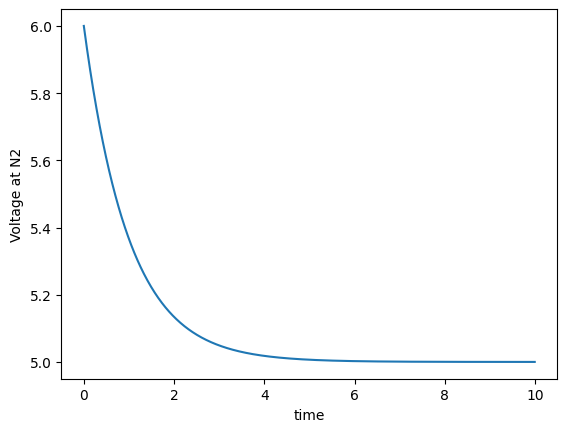

In [661]:
plt.plot(np.arange(0, 10, 0.01), measurement["N2"])
plt.ylabel("Voltage at N2")
plt.xlabel("time")
plt.show()